🔍 CV 경진대회 EDA 시작
1. 데이터셋 기본 정보
클래스 정보:
    target                                         class_name
0        0                                     account_number
1        1  application_for_payment_of_pregnancy_medical_e...
2        2                                      car_dashboard
3        3            confirmation_of_admission_and_discharge
4        4                                          diagnosis
5        5                                     driver_lisence
6        6                              medical_bill_receipts
7        7                     medical_outpatient_certificate
8        8                                   national_id_card
9        9                                           passport
10      10                               payment_confirmation
11      11                             pharmaceutical_receipt
12      12                                       prescription
13      13                                             resume
14      14                     

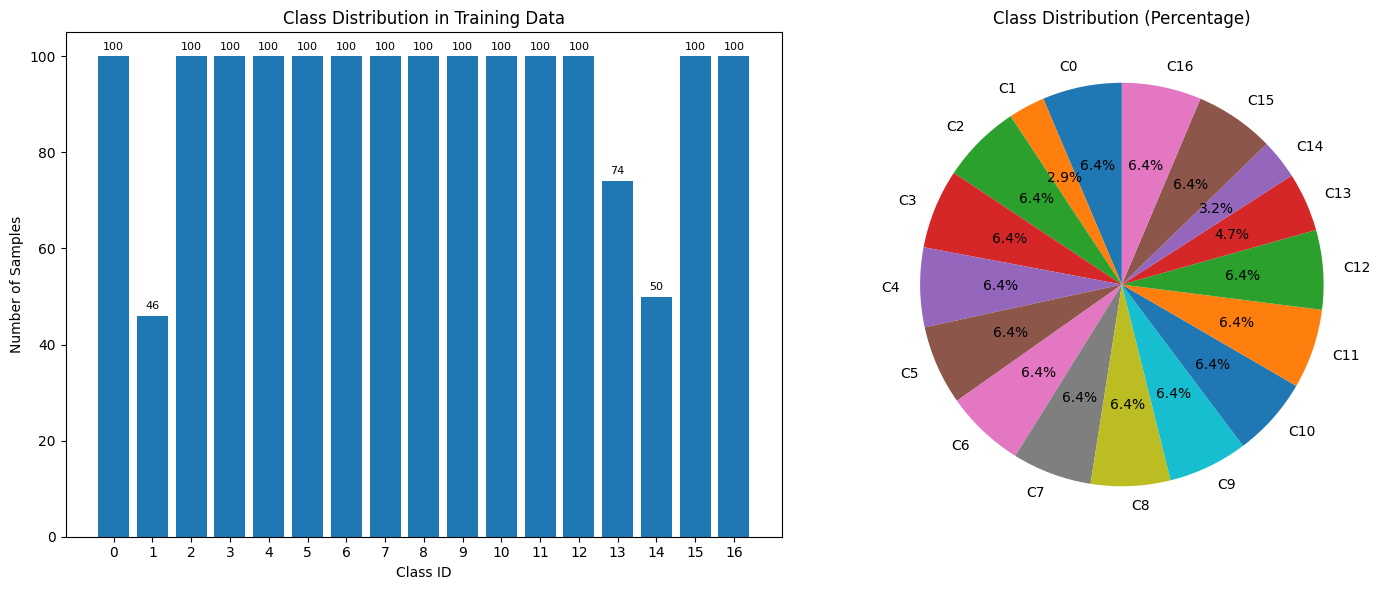


3. 이미지 속성 분석
훈련 이미지 속성 분석 중... (100개 샘플)
테스트 이미지 속성 분석 중... (100개 샘플)

훈련 이미지 통계:
  평균 파일 크기: 75.79 KB
  평균 픽셀 수: 261,773
  가장 흔한 해상도 (상위 5개):
    443x591: 68개
    591x443: 18개
    682x384: 1개
    591x442: 1개
    608x430: 1개

테스트 이미지 통계:
  평균 파일 크기: 82.63 KB
  평균 픽셀 수: 261,783
  가장 흔한 해상도 (상위 5개):
    591x443: 46개
    443x591: 34개
    682x384: 2개
    413x633: 1개
    406x645: 1개

4. 클래스별 샘플 이미지 확인


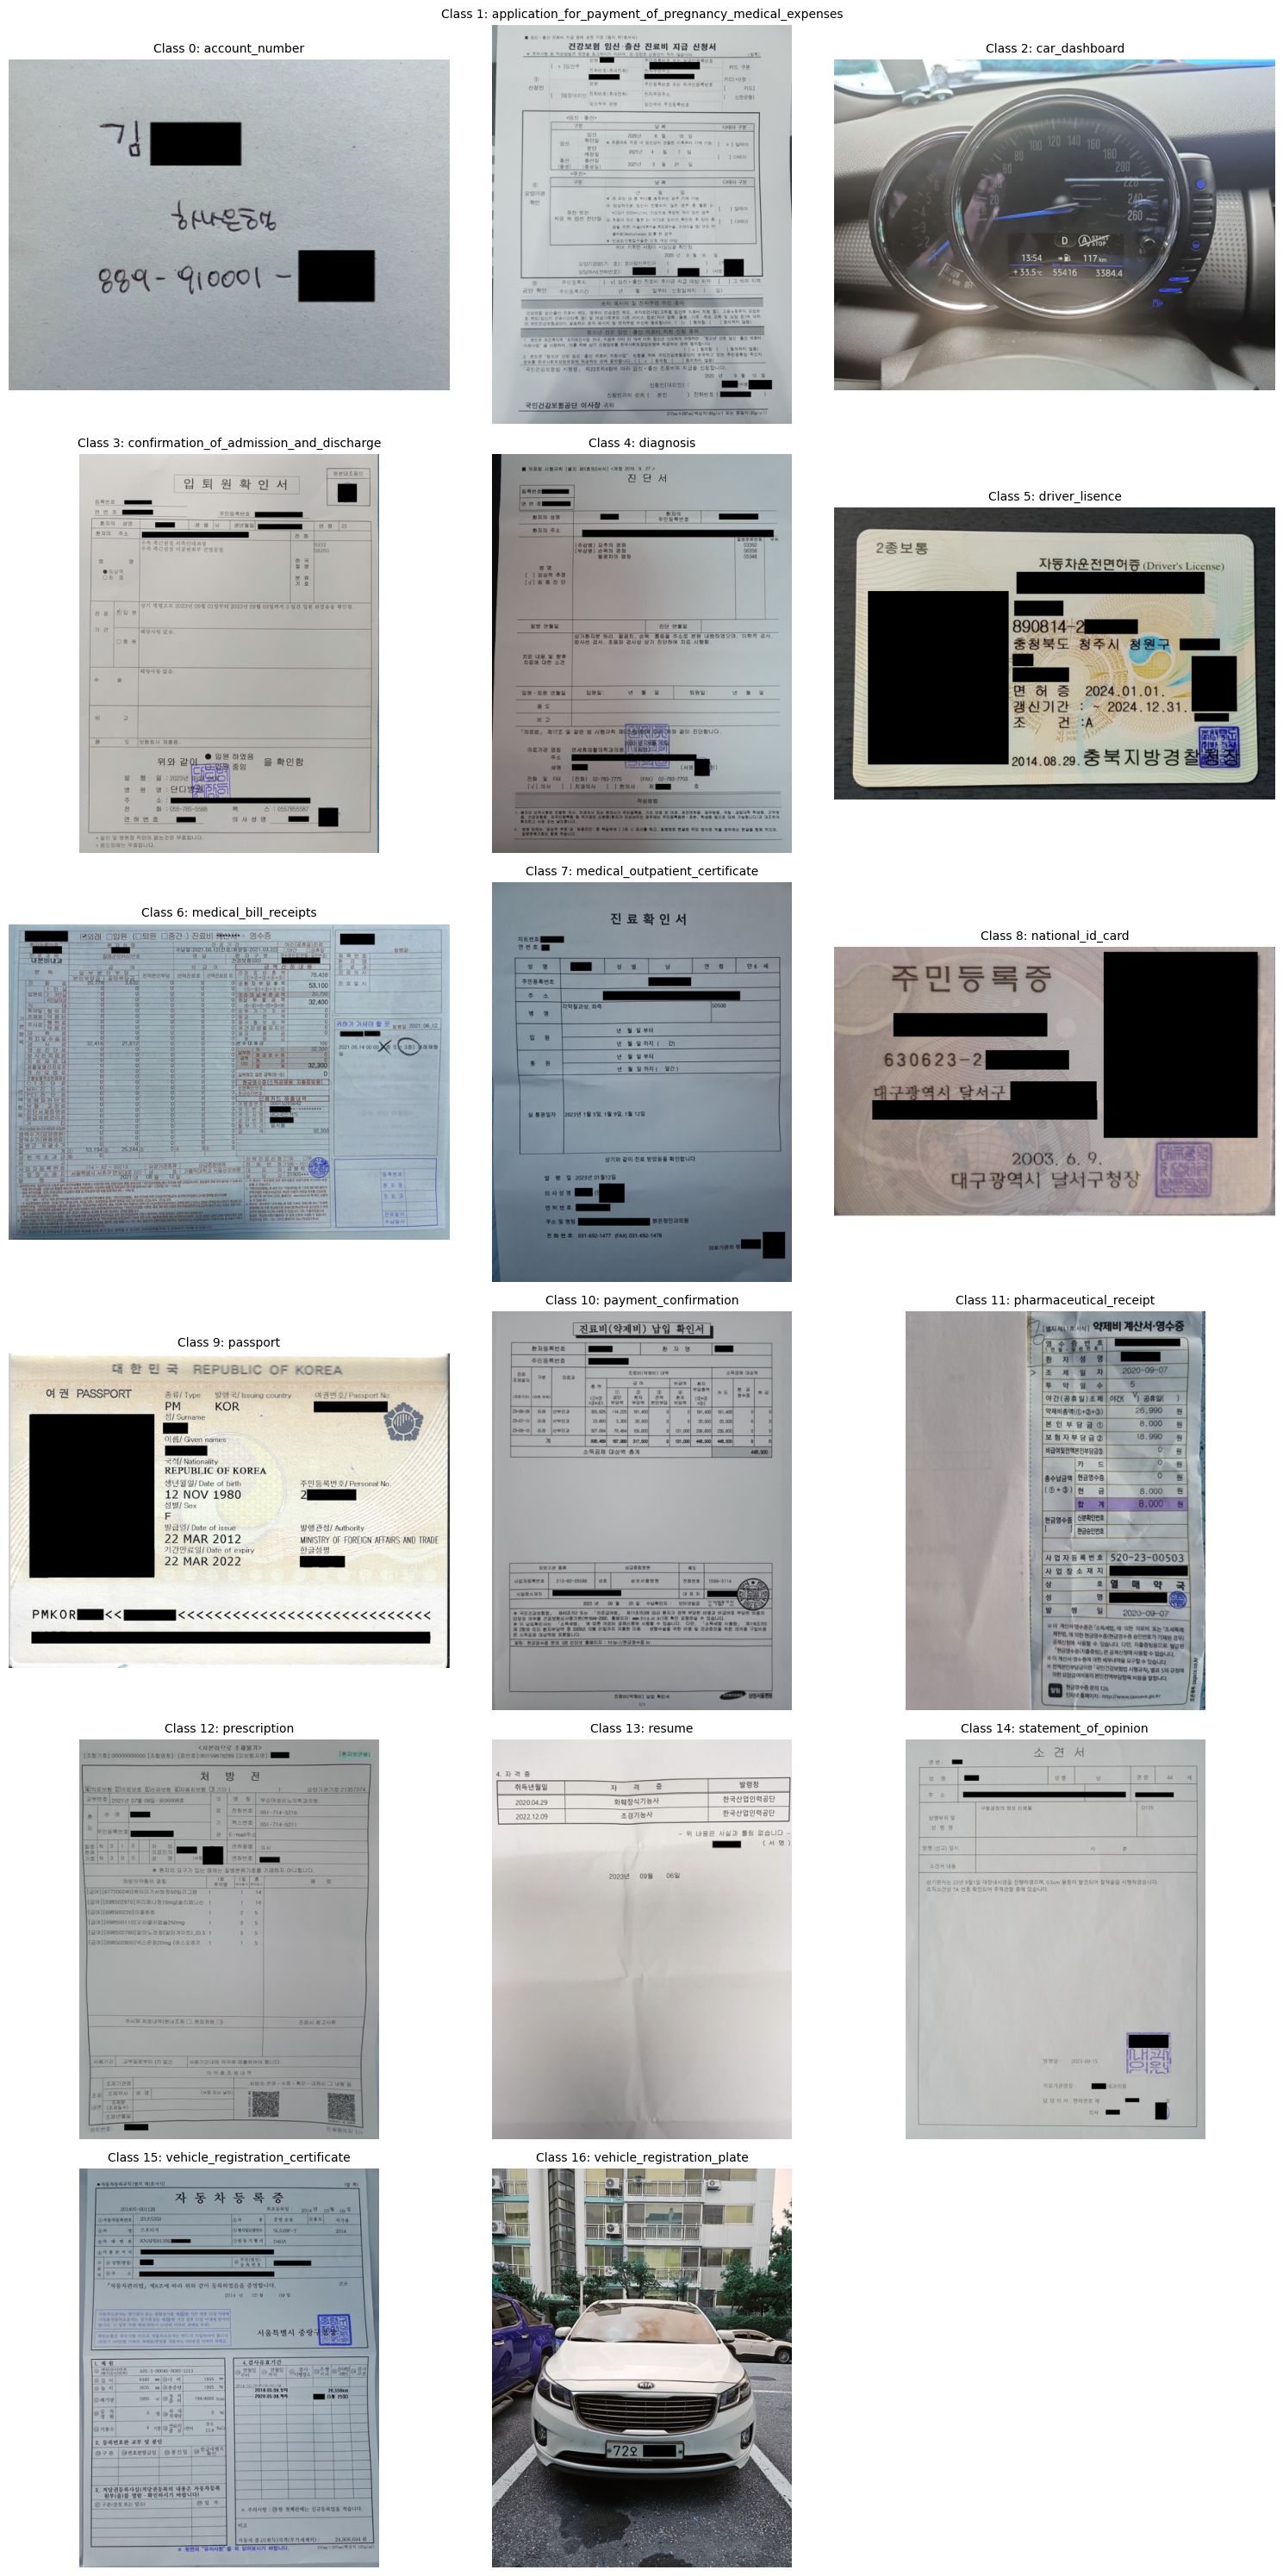


5. 이미지 품질 분석
훈련 이미지 품질 분석 중...
테스트 이미지 품질 분석 중...


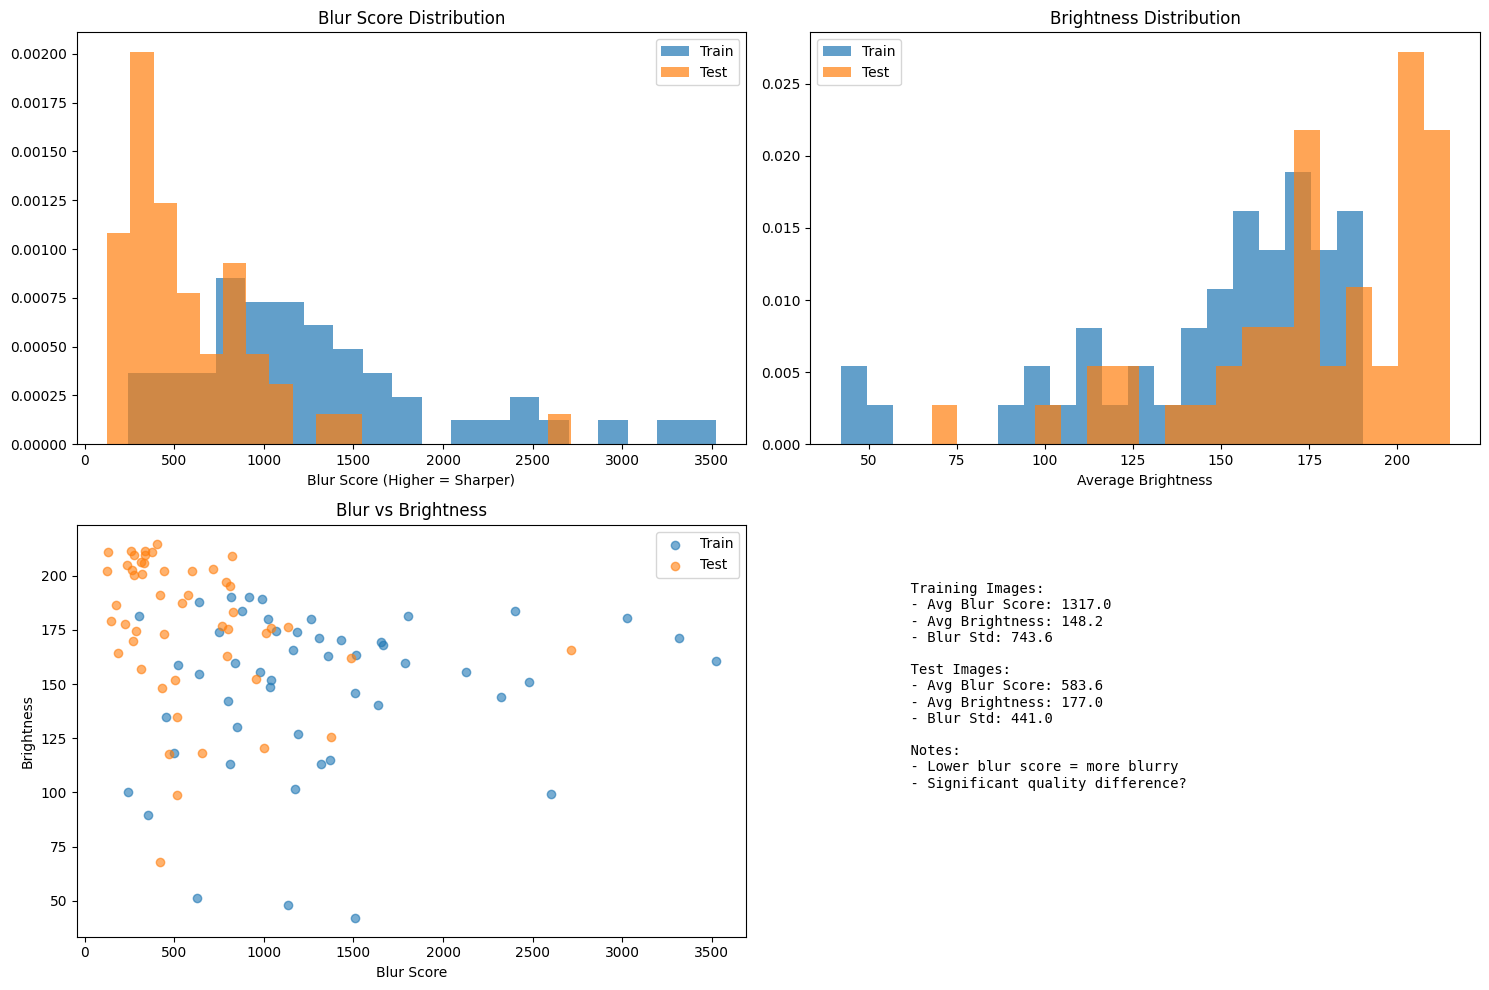


6. 개선사항 제안
A. 클래스 불균형 문제:
  ✅ 적당한 클래스 불균형 (비율: 2.17)

B. 이미지 해상도 최적화:
  💡 현재 224x224 사용 중 - ImageNet 사전학습에 적합
  💡 문서 이미지 특성상 고해상도가 도움될 수 있음
     - 384x384 또는 512x512 실험 고려

C. 데이터 증강 전략:
  ⚠️  테스트 이미지가 훈련 이미지보다 블러함
  💡 개선방안:
     - 블러 증강 추가 (GaussianBlur, MotionBlur)
     - 노이즈 추가 강화

D. 모델 아키텍처 제안:
  💡 문서 분류 특화 개선안:
     - EfficientNet 계열 실험 (파라미터 효율성)
     - Vision Transformer (문서 레이아웃 이해에 유리)
     - 멀티스케일 특성 추출을 위한 FPN 추가

E. 앙상블 전략:
  💡 현재 K-Fold + TTA 적용 중
  💡 추가 고려사항:
     - 다양한 모델 앙상블 (ResNet + EfficientNet)
     - 다양한 해상도 앙상블
     - Pseudo Labeling (규정 확인 필요)

✅ EDA 완료!
📊 생성된 시각화 파일:
   - class_distribution.png
   - sample_images_by_class.png
   - image_quality_analysis.png


In [1]:
# CV 경진대회 EDA (Exploratory Data Analysis)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
from collections import Counter
import cv2

# 한글 폰트 설정 (시각화용)
plt.rcParams['font.family'] = ['DejaVu Sans']

# 1. 데이터 기본 정보 탐색
def basic_data_info():
    """
    데이터셋의 기본 정보를 탐색하는 함수
    - 파일 구조, 클래스 분포, 기본 통계 등
    """
    print("="*50)
    print("1. 데이터셋 기본 정보")
    print("="*50)
    
    # 메타데이터 확인
    meta_df = pd.read_csv("../data/meta.csv")
    print("클래스 정보:")
    print(meta_df)
    print(f"\n총 클래스 수: {len(meta_df)}")
    
    # 훈련 데이터 클래스 분포 확인
    train_df = pd.read_csv("../data/train.csv")
    print(f"\n훈련 데이터 샘플 수: {len(train_df)}")
    
    # 클래스별 분포 확인
    class_counts = train_df['target'].value_counts().sort_index()
    print("\n클래스별 샘플 수:")
    for class_id, count in class_counts.items():
        class_name = meta_df[meta_df['target'] == class_id]['class_name'].iloc[0]
        print(f"Class {class_id:2d} ({class_name:20s}): {count:3d}개")
    
    # 클래스 불균형 확인
    min_samples = class_counts.min()
    max_samples = class_counts.max()
    imbalance_ratio = max_samples / min_samples
    print(f"\n클래스 불균형 비율: {imbalance_ratio:.2f} (최대/최소)")
    
    return train_df, meta_df

def visualize_class_distribution(train_df, meta_df):
    """
    클래스 분포를 시각화하는 함수
    """
    print("\n2. 클래스 분포 시각화")
    print("="*50)
    
    plt.figure(figsize=(15, 6))
    
    # 클래스별 샘플 수 막대 그래프
    class_counts = train_df['target'].value_counts().sort_index()
    
    plt.subplot(1, 2, 1)
    bars = plt.bar(class_counts.index, class_counts.values)
    plt.title('Class Distribution in Training Data')
    plt.xlabel('Class ID')
    plt.ylabel('Number of Samples')
    plt.xticks(range(17))
    
    # 막대에 값 표시
    for i, bar in enumerate(bars):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 1,
                f'{int(height)}', ha='center', va='bottom', fontsize=8)
    
    # 클래스 불균형 정도를 pie chart로 표시
    plt.subplot(1, 2, 2)
    plt.pie(class_counts.values, labels=[f'C{i}' for i in class_counts.index], 
           autopct='%1.1f%%', startangle=90)
    plt.title('Class Distribution (Percentage)')
    
    plt.tight_layout()
    plt.savefig('class_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return class_counts

def analyze_image_properties():
    """
    이미지 파일들의 속성을 분석하는 함수
    - 이미지 크기, 채널, 파일 크기 등
    """
    print("\n3. 이미지 속성 분석")
    print("="*50)
    
    train_path = "../data/train/"
    test_path = "../data/test/"
    
    # 훈련 데이터 이미지 속성 분석
    train_files = os.listdir(train_path)[:100]  # 샘플링 (100개만)
    train_sizes = []
    train_shapes = []
    train_file_sizes = []
    
    print("훈련 이미지 속성 분석 중... (100개 샘플)")
    for file in train_files:
        if file.endswith('.jpg'):
            img_path = os.path.join(train_path, file)
            
            # 파일 크기
            file_size = os.path.getsize(img_path) / 1024  # KB 단위
            train_file_sizes.append(file_size)
            
            # 이미지 속성
            img = Image.open(img_path)
            train_shapes.append(img.size)  # (width, height)
            train_sizes.append(img.size[0] * img.size[1])  # 총 픽셀 수
    
    # 테스트 데이터 이미지 속성 분석
    test_files = os.listdir(test_path)[:100]  # 샘플링 (100개만)
    test_sizes = []
    test_shapes = []
    test_file_sizes = []
    
    print("테스트 이미지 속성 분석 중... (100개 샘플)")
    for file in test_files:
        if file.endswith('.jpg'):
            img_path = os.path.join(test_path, file)
            
            # 파일 크기
            file_size = os.path.getsize(img_path) / 1024  # KB 단위
            test_file_sizes.append(file_size)
            
            # 이미지 속성
            img = Image.open(img_path)
            test_shapes.append(img.size)
            test_sizes.append(img.size[0] * img.size[1])
    
    # 결과 정리
    print("\n훈련 이미지 통계:")
    print(f"  평균 파일 크기: {np.mean(train_file_sizes):.2f} KB")
    print(f"  평균 픽셀 수: {np.mean(train_sizes):,.0f}")
    
    # 가장 흔한 해상도 찾기
    shape_counter = Counter(train_shapes)
    most_common_shape = shape_counter.most_common(5)
    print("  가장 흔한 해상도 (상위 5개):")
    for shape, count in most_common_shape:
        print(f"    {shape[0]}x{shape[1]}: {count}개")
    
    print("\n테스트 이미지 통계:")
    print(f"  평균 파일 크기: {np.mean(test_file_sizes):.2f} KB")
    print(f"  평균 픽셀 수: {np.mean(test_sizes):,.0f}")
    
    # 가장 흔한 해상도 찾기
    shape_counter = Counter(test_shapes)
    most_common_shape = shape_counter.most_common(5)
    print("  가장 흔한 해상도 (상위 5개):")
    for shape, count in most_common_shape:
        print(f"    {shape[0]}x{shape[1]}: {count}개")
    
    return {
        'train': {'sizes': train_sizes, 'shapes': train_shapes, 'file_sizes': train_file_sizes},
        'test': {'sizes': test_sizes, 'shapes': test_shapes, 'file_sizes': test_file_sizes}
    }

def sample_images_by_class(train_df, meta_df, num_samples=3):
    """
    각 클래스별로 샘플 이미지를 표시하는 함수
    """
    print("\n4. 클래스별 샘플 이미지 확인")
    print("="*50)
    
    train_path = "../data/train/"
    
    # 17개 클래스가 있으므로 적절한 그리드 크기 설정
    fig, axes = plt.subplots(6, 3, figsize=(15, 30))  # 6x3 = 18칸 (17클래스 + 1여분)
    axes = axes.flatten()
    
    for class_id in range(17):
        class_name = meta_df[meta_df['target'] == class_id]['class_name'].iloc[0]
        
        # 해당 클래스의 이미지 파일들 찾기
        class_files = train_df[train_df['target'] == class_id]['ID'].tolist()
        
        if class_files:
            # 첫 번째 이미지를 대표로 선택
            sample_file = class_files[0]
            img_path = os.path.join(train_path, sample_file)
            
            if os.path.exists(img_path):
                img = Image.open(img_path)
                axes[class_id].imshow(img)
                axes[class_id].set_title(f'Class {class_id}: {class_name}', fontsize=10)
                axes[class_id].axis('off')
            else:
                axes[class_id].text(0.5, 0.5, 'Image Not Found', 
                                   ha='center', va='center', transform=axes[class_id].transAxes)
                axes[class_id].set_title(f'Class {class_id}: {class_name}', fontsize=10)
    
    # 마지막 빈 칸 제거
    if len(axes) > 17:
        axes[17].axis('off')
    
    plt.tight_layout()
    plt.savefig('sample_images_by_class.png', dpi=300, bbox_inches='tight')
    plt.show()

def analyze_image_quality_issues():
    """
    이미지 품질 문제를 분석하는 함수
    - 블러, 노이즈, 밝기 등
    """
    print("\n5. 이미지 품질 분석")
    print("="*50)
    
    train_path = "../data/train/"
    test_path = "../data/test/"
    
    def calculate_blur_score(image_path):
        """라플라시안 분산을 사용한 블러 점수 계산"""
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            return cv2.Laplacian(img, cv2.CV_64F).var()
        return 0
    
    def calculate_brightness(image_path):
        """이미지 평균 밝기 계산"""
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            return np.mean(img)
        return 0
    
    # 샘플 분석 (시간 절약을 위해 50개씩만)
    train_files = os.listdir(train_path)[:50]
    test_files = os.listdir(test_path)[:50]
    
    train_blur_scores = []
    train_brightness = []
    test_blur_scores = []
    test_brightness = []
    
    print("훈련 이미지 품질 분석 중...")
    for file in train_files:
        if file.endswith('.jpg'):
            img_path = os.path.join(train_path, file)
            blur_score = calculate_blur_score(img_path)
            brightness = calculate_brightness(img_path)
            
            train_blur_scores.append(blur_score)
            train_brightness.append(brightness)
    
    print("테스트 이미지 품질 분석 중...")
    for file in test_files:
        if file.endswith('.jpg'):
            img_path = os.path.join(test_path, file)
            blur_score = calculate_blur_score(img_path)
            brightness = calculate_brightness(img_path)
            
            test_blur_scores.append(blur_score)
            test_brightness.append(brightness)
    
    # 결과 시각화
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # 블러 점수 분포
    axes[0, 0].hist(train_blur_scores, bins=20, alpha=0.7, label='Train', density=True)
    axes[0, 0].hist(test_blur_scores, bins=20, alpha=0.7, label='Test', density=True)
    axes[0, 0].set_title('Blur Score Distribution')
    axes[0, 0].set_xlabel('Blur Score (Higher = Sharper)')
    axes[0, 0].legend()
    
    # 밝기 분포
    axes[0, 1].hist(train_brightness, bins=20, alpha=0.7, label='Train', density=True)
    axes[0, 1].hist(test_brightness, bins=20, alpha=0.7, label='Test', density=True)
    axes[0, 1].set_title('Brightness Distribution')
    axes[0, 1].set_xlabel('Average Brightness')
    axes[0, 1].legend()
    
    # 산점도
    axes[1, 0].scatter(train_blur_scores, train_brightness, alpha=0.6, label='Train')
    axes[1, 0].scatter(test_blur_scores, test_brightness, alpha=0.6, label='Test')
    axes[1, 0].set_xlabel('Blur Score')
    axes[1, 0].set_ylabel('Brightness')
    axes[1, 0].set_title('Blur vs Brightness')
    axes[1, 0].legend()
    
    # 통계 요약
    axes[1, 1].axis('off')
    stats_text = f"""
    Training Images:
    - Avg Blur Score: {np.mean(train_blur_scores):.1f}
    - Avg Brightness: {np.mean(train_brightness):.1f}
    - Blur Std: {np.std(train_blur_scores):.1f}
    
    Test Images:
    - Avg Blur Score: {np.mean(test_blur_scores):.1f}
    - Avg Brightness: {np.mean(test_brightness):.1f}
    - Blur Std: {np.std(test_blur_scores):.1f}
    
    Notes:
    - Lower blur score = more blurry
    - Significant quality difference?
    """
    axes[1, 1].text(0.1, 0.9, stats_text, transform=axes[1, 1].transAxes, 
                   fontfamily='monospace', verticalalignment='top')
    
    plt.tight_layout()
    plt.savefig('image_quality_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return {
        'train_blur': train_blur_scores,
        'train_brightness': train_brightness,
        'test_blur': test_blur_scores,
        'test_brightness': test_brightness
    }

def suggest_improvements(class_counts, image_stats, quality_stats):
    """
    분석 결과를 바탕으로 개선사항을 제안하는 함수
    """
    print("\n6. 개선사항 제안")
    print("="*50)
    
    # 클래스 불균형 문제
    min_samples = class_counts.min()
    max_samples = class_counts.max()
    imbalance_ratio = max_samples / min_samples
    
    print("A. 클래스 불균형 문제:")
    if imbalance_ratio > 3:
        print(f"  ⚠️  심각한 클래스 불균형 (비율: {imbalance_ratio:.2f})")
        print("  💡 개선방안:")
        print("     - 가중치 손실 함수 사용 (class_weight 파라미터)")
        print("     - 소수 클래스에 대한 추가 증강")
        print("     - Focal Loss 적용 고려")
    else:
        print(f"  ✅ 적당한 클래스 불균형 (비율: {imbalance_ratio:.2f})")
    
    # 이미지 해상도 문제
    print("\nB. 이미지 해상도 최적화:")
    print("  💡 현재 224x224 사용 중 - ImageNet 사전학습에 적합")
    print("  💡 문서 이미지 특성상 고해상도가 도움될 수 있음")
    print("     - 384x384 또는 512x512 실험 고려")
    
    # 데이터 증강 전략
    avg_train_blur = np.mean(quality_stats['train_blur'])
    avg_test_blur = np.mean(quality_stats['test_blur'])
    
    print("\nC. 데이터 증강 전략:")
    if avg_test_blur < avg_train_blur * 0.8:
        print("  ⚠️  테스트 이미지가 훈련 이미지보다 블러함")
        print("  💡 개선방안:")
        print("     - 블러 증강 추가 (GaussianBlur, MotionBlur)")
        print("     - 노이즈 추가 강화")
    
    # 밝기 차이 분석
    train_bright_std = np.std(quality_stats['train_brightness'])
    test_bright_std = np.std(quality_stats['test_brightness'])
    
    if test_bright_std > train_bright_std * 1.2:
        print("  ⚠️  테스트 이미지의 밝기 편차가 큼")
        print("  💡 개선방안:")
        print("     - RandomBrightnessContrast 범위 확대")
        print("     - 히스토그램 균등화 추가 고려")
    
    print("\nD. 모델 아키텍처 제안:")
    print("  💡 문서 분류 특화 개선안:")
    print("     - EfficientNet 계열 실험 (파라미터 효율성)")
    print("     - Vision Transformer (문서 레이아웃 이해에 유리)")
    print("     - 멀티스케일 특성 추출을 위한 FPN 추가")
    
    print("\nE. 앙상블 전략:")
    print("  💡 현재 K-Fold + TTA 적용 중")
    print("  💡 추가 고려사항:")
    print("     - 다양한 모델 앙상블 (ResNet + EfficientNet)")
    print("     - 다양한 해상도 앙상블")
    print("     - Pseudo Labeling (규정 확인 필요)")

# 메인 실행 함수
def run_eda():
    """
    전체 EDA를 실행하는 메인 함수
    """
    print("🔍 CV 경진대회 EDA 시작")
    print("="*60)
    
    try:
        # 1. 기본 정보 분석
        train_df, meta_df = basic_data_info()
        
        # 2. 클래스 분포 시각화
        class_counts = visualize_class_distribution(train_df, meta_df)
        
        # 3. 이미지 속성 분석
        image_stats = analyze_image_properties()
        
        # 4. 클래스별 샘플 이미지
        sample_images_by_class(train_df, meta_df)
        
        # 5. 이미지 품질 분석
        quality_stats = analyze_image_quality_issues()
        
        # 6. 개선사항 제안
        suggest_improvements(class_counts, image_stats, quality_stats)
        
        print("\n✅ EDA 완료!")
        print("📊 생성된 시각화 파일:")
        print("   - class_distribution.png")
        print("   - sample_images_by_class.png") 
        print("   - image_quality_analysis.png")
        
    except Exception as e:
        print(f"❌ EDA 실행 중 오류 발생: {e}")
        print("데이터 경로와 파일 존재 여부를 확인해주세요.")

# 실행
if __name__ == "__main__":
    run_eda()